# Data Analysis

  ## Library Imports

In [1]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Database connection

Firstly, we establish a connection to the *PostgreSQL* database using methods from the `psycopg2` and `sqlalchemy` libraries. 

In [2]:
# Credentials to connect to Postgres database
database= "grp21_vaccinedist"   
user= 'grp21'       
password= 'B5!BpWYT' 
host= 'dbcourse2022.cs.aalto.fi'
port= '5432'

try:
    connection = psycopg2.connect(
                                    database=database,              
                                    user=user,       
                                    password=password,   
                                    host=host,
                                    port=port
                                )
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
    DIALECT = 'postgresql+psycopg2://'
    db_uri = "%s:%s@%s/%s" % (user, password, host, database)
    engine = create_engine(DIALECT + db_uri)
    psql_conn  = engine.connect()

except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

You are connected to -  ('PostgreSQL 12.11 (Ubuntu 12.11-0ubuntu0.20.04.1) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0, 64-bit',) 



With the connection established, we can proceed to conducting the analysis tasks.

## Data analysis

### Problem 1: 
#### Create a dataframe for patients and symptoms containing the following columns: (1) ssNO, (2) gender, (3) dateOfBirth, (4)symptom, (5) diagnosisDate. Create a corresponding table named ”PatientSymptoms”.

Let's start by pulling data about patients and symptoms from the database into a pandas dataframe using an SQL query.

In [3]:
query = '''
    SELECT ssno, gender, birthday, symptom, date
    FROM patient, diagnosed
    WHERE patient = ssno
'''
df = pd.read_sql(query, psql_conn)
df.head()

,ssno,gender,birthday,symptom,date
0,790503-394M,F,1979-05-03,anaphylaxia,2021-01-30
1,000127-4899,F,2000-01-27,blurring of vision,2021-02-01
2,090707-295R,F,2009-07-07,chest pain,2021-02-15
3,810616-9029,M,1981-06-16,chest pain,2021-04-30
4,701127-5340,F,1970-11-27,chills,2021-04-10


Now we can create a table using the dataframe we obtained.

In [4]:
df.to_sql("patientsymptoms", psql_conn, index = True, if_exists = "replace")

95

We can check that the table has been successfully inserted into the database.

In [5]:
query = '''
    SELECT *
    FROM patientsymptoms
'''
df = pd.read_sql(query, psql_conn)
df.head()

,index,ssno,gender,birthday,symptom,date
0,0,790503-394M,F,1979-05-03,anaphylaxia,2021-01-30
1,1,000127-4899,F,2000-01-27,blurring of vision,2021-02-01
2,2,090707-295R,F,2009-07-07,chest pain,2021-02-15
3,3,810616-9029,M,1981-06-16,chest pain,2021-04-30
4,4,701127-5340,F,1970-11-27,chills,2021-04-10


### Problem 2
#### Create a dataframe for patients and vaccines containing the following columns: (1)patientssNO, (2)date1, (3)vaccinetype1, (4) date2, (5) vaccinetype2. The attribute ”date1” and ”date2” refer to the date when the first and/or second dose were given to a patient respectively. Similarly, ”vaccinetype1” and ”vaccinetype2” are the type of vaccine used for the first and/or second dose.

For this problem we can start by creating a view that lists some information about every performed vaccination.

In [6]:
%%capture

query = '''
    CREATE OR REPLACE VIEW individualvaccination AS
    SELECT attend.patient AS patientssno, attend.date, vaccinedata.name as vaccinetype
    FROM   
        attend 
        NATURAL JOIN 
        vaccinationevent 
        NATURAL JOIN 
        vaccinationbatch 
        NATURAL JOIN 
        vaccinedata
    
'''
psql_conn.execute(query)

We can now use the created view in constructing the desired dataframe.

In [7]:
query = '''
    SELECT ssno AS patientssno, IV1.date AS date1, IV1.vaccinetype AS vaccinetype1,
        IV2.date AS date2, IV2.vaccinetype ASvaccinetype2
    FROM 
        patient
        LEFT JOIN individualvaccination AS IV1 ON ssno = IV1.patientssno
        LEFT JOIN individualvaccination AS IV2 ON ssno = IV2.patientssno AND IV1.date <> IV2.date
    WHERE IV1.date < IV2.date OR IV2.date IS NULL OR IV1.date IS NULL
'''

df = pd.read_sql(query, psql_conn)
df.sort_values('date1').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patientssno     150 non-null    object
 1   date1           87 non-null     object
 2   vaccinetype1    87 non-null     object
 3   date2           12 non-null     object
 4   asvaccinetype2  12 non-null     object
dtypes: object(5)
memory usage: 7.0+ KB


Here I assumed that a patient can only receive one vaccine in any given day. This assumption was also made during the database design process, so nothing new here. 

Now we can proceed to creating a table based on the newly constructed dataframe.

In [8]:
df.to_sql("patientvaccineinfo", psql_conn, if_exists = "replace")

query = '''
    SELECT *
    FROM patientvaccineinfo
'''
pd.read_sql(query, psql_conn).head()

,index,patientssno,date1,vaccinetype1,date2,asvaccinetype2
0,0,841229-112N,2021-01-30,AstraZeneca,2021-02-14,Comirnaty
1,1,780214-1893,2021-01-30,AstraZeneca,None,None
2,2,731122-126T,2021-01-30,AstraZeneca,None,None
3,3,160930-586P,2021-01-30,AstraZeneca,2021-02-14,Comirnaty
4,4,930106-189U,2021-01-30,AstraZeneca,None,None


### Problem 3
#### Create a dataframe using the table ”PatientSymptoms” and separate it into two dataframes, one for males and one for females.

For this problem, first I will join <code>Diagnosed</code> and <code>Patient</code>, so we can get a dataframe with the symptoms as well as patient's information

In [9]:
# Read the neccessary dataframes
diagnosed = pd.read_sql('SELECT * FROM diagnosed;', psql_conn)
patient = pd.read_sql('SELECT * FROM patient;', psql_conn)

# I create a new dataframe diagnosed_to_merge so I can freely manipulate it without affecting the original dataframe. I also rename the column patient into ssno to perfrom an inner
# join with patient
diagnosed_to_merge = diagnosed.copy().rename(columns={'patient':'ssno'})
question3 = diagnosed_to_merge.merge(patient, how='inner')
question3.head()

,ssno,symptom,date,name,birthday,gender
0,790503-394M,anaphylaxia,2021-01-30,Kathlyn Moore,1979-05-03,F
1,000127-4899,blurring of vision,2021-02-01,Ms. Opal Lang,2000-01-27,F
2,000127-4899,fever,2021-02-01,Ms. Opal Lang,2000-01-27,F
3,090707-295R,chest pain,2021-02-15,Alysson Jakubowski,2009-07-07,F
4,090707-295R,muscle ache,2021-02-15,Alysson Jakubowski,2009-07-07,F


After I got the joined table, I will perform what the question asked. This is accomplised through some <code>groupby</code> with the aggregation function <code>count</code> and sorting using the count of patients:

In [10]:
# Creating the table for female patients and group them according to the number of person getting the symptoms
question3_f = question3[question3['gender'] == 'F'].groupby('symptom', as_index=False).agg('count').sort_values(by=['ssno'], ascending=False)
print('The most three frequent symptoms in female patients are:\n')
question3_f[['symptom', 'ssno']].head(3)

The most three frequent symptoms in female patients are:



,symptom,ssno
13,muscle ache,8
8,headache,7
6,feelings of illness,4


In [11]:
# Creating the table for male patients and group them according to the number of person getting the symptoms
question3_m = question3[question3['gender'] == 'M'].groupby('symptom', as_index=False).agg('count').sort_values(by=['ssno'], ascending=False)
print('\n\nThe most three frequent symptoms in male patients are:\n')
question3_m[['symptom', 'ssno']].head(3)



The most three frequent symptoms in male patients are:



,symptom,ssno
9,joint pain,10
10,muscle ache,7
4,fever,6


From the result, we can see that for female patients, the most three frequent symptoms are <code>muscle ache</code>, <code>headache</code>, and <code>feelings of illness</code>, while for males they are <code>joint pain</code>, <code>muscle ache</code>, and <code>fever</code>.

### Problem 4
#### Create a dataframe using table ”Patient” and add the ”ageGroup” column for each patient. The age groups are ”0-10”, ”10-20”, ”20-40”, ”40-60”, ”60+”.

First, let's take a look at our Patient tables and its datatypes:

In [12]:
question4 = patient.copy()
question4.head()

,ssno,name,birthday,gender
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M
3,730218-253D,Dereck Beer,1973-02-18,M
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M


In [13]:
question4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ssno      150 non-null    object
 1   name      150 non-null    object
 2   birthday  150 non-null    object
 3   gender    150 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


As we can see, to get the age, first we will need to convert the birthday into Datetime so we can make the subtraction to get the age.

In [14]:
question4['birthday'] = pd.to_datetime(question4['birthday'])

After we have the birthday in the correct format, let's perform the subtraction to get the age. For this question, I will calculate the age up until the day that the script is being run.

In [15]:
today = pd.to_datetime(pd.to_datetime("today").strftime("%Y-%m-%d"))
question4['ageGroup'] = question4['birthday'].apply(
            lambda x: today.year - x.year - 
            ((today.month, today.day) < (x.month, x.day)) 
            )

question4['ageGroup'] = pd.cut(question4['ageGroup'], bins=[0, 10, 20, 40, 60, np.inf], right=False, include_lowest=True)
question4['ageGroup'] = question4['ageGroup'].cat.rename_categories(['0-9', '10-19', '20-39', '40-59', '60+'])
question4.head()

,ssno,name,birthday,gender,ageGroup
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,20-39
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F,40-59
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,20-39
3,730218-253D,Dereck Beer,1973-02-18,M,40-59
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,20-39


As seen from above, I have both calculate the date and group them in one code cell, and now I will explain what I have done:
* For the age calculating part, I take current date without the time and minus it to the <code>birthday</code> column, I also additionally minus the part <code>((today.month, today.day) < (x.month, x.day))</code>. This part will result in <code>0</code> if the timestamp is after the birthday of the patient, and it will only be the current year minus the birth year. But if the timestamp is not yet the birthday of the patient, <code>((today.month, today.day) < (x.month, x.day))</code> will results in <code>1</code>, and the age of the patient will be one less.
* For the age grouping, first I cut the <code>ageGroup</code> column into 5 bins as indicated in the task description. Also, I choose to make the bins left inclusive but not right inclusive. I choose it this way as the lowest bin is <code>[0,10)</code>, and the highest bin is <code>[60, np.inf)</code>. Thus, it makes sense to include those with 0 ages and exclude those with infinity age (though this is never achieved in real life). After I got the age bins, I renamed those bins so that they match with what is expected.

### Problem 5
#### Using the same dataframe in problem 4, add a column describing each patient’s vaccination status. The statuses are defined as ”0” for not vaccinated, ”1” for vaccinated once, and ”2” for fully-vaccinated

To approach this problem, I did the following:
- First, I create a dataframe that has the information about the patients and their age groups. This can be easily done by copying the dataframe from part 4
- Second, I create a dataframe that has the information about the patients and their vaccination status (i.e., how many doses they had). This can be achieved by these 2 steps:
    - Query to find all the patients that have attended some vaccination events, and count how many did they attend (i.e., vaccination status 1 or 2)
    - Query to find patients that have not attended any vaccination events, so their vaccination status is 0

In [16]:
# create a dataframe of patients with their age groups
patient_with_agegroup = question4.copy()
patient_with_agegroup.head()

,ssno,name,birthday,gender,ageGroup
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,20-39
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F,40-59
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,20-39
3,730218-253D,Dereck Beer,1973-02-18,M,40-59
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,20-39


In [17]:
# create a dataframe of patients with their vaccination status
print()
sql_query = """
(SELECT patient.ssno,
        patient.name,
        patient.birthday,
        patient.gender,
        COUNT(attend.date) AS vaccinationstatus
    FROM patient,
        attend
    WHERE attend.patient = patient.ssNo
    GROUP BY patient.ssno)
    UNION
    (SELECT patient.ssno,
        patient.name,
        patient.birthday,
        patient.gender,
        0
    FROM patient
    WHERE patient.ssNo NOT IN (SELECT patient FROM attend));"""

patient_with_vaccinationstt = pd.read_sql_query(sql_query, psql_conn)
patient_with_vaccinationstt['birthday'] = pd.to_datetime(patient_with_vaccinationstt['birthday'])
patient_with_vaccinationstt.head()

,ssno,name,birthday,gender,vaccinationstatus
0,060406-686D,Dovie West,2006-04-06,F,1
1,741104-114G,Marvin Fahey,1974-11-04,M,1
2,720414-668E,Paige Conn,1972-04-14,F,0
3,930804-7021,Prof. Harrison Toy,1993-08-04,M,1
4,010327-525G,Dr. Mireille Hansen,2001-03-27,M,2


After that, we can join these 2 dataframes with inner join and get a dataframe that has information about patients, their age group and their vaccination status.

In [18]:
question5 = patient_with_agegroup.merge(patient_with_vaccinationstt, how='inner', on=['ssno', 'name', 'birthday', 'gender'])
question5.head()

,ssno,name,birthday,gender,ageGroup,vaccinationstatus
0,841229-112N,Rodolfo O'Reilly,1984-12-29,M,20-39,2
1,780214-1893,Prof. Erling Morar MD,1978-02-14,F,40-59,1
2,950303-191X,Dr. Simeon Keeling II,1995-03-03,M,20-39,1
3,730218-253D,Dereck Beer,1973-02-18,M,40-59,1
4,971214-2818,Prof. Brice Metz PhD,1997-12-14,M,20-39,1


### Problem 6
#### For each age group, calculate the percentage of people who have received zero, one, or two doses of vaccines. Show the results in a dataframe, where the index is the vaccination status from problem 5 and the columns are the age groups.

The code cell right below this cell contains all the code to produce the answer to question 6.

For more explanations about the approach and process of solving this question, check out the cells below the next code cell.

In [19]:
def cal_percentage(column:pd.Series) -> pd.Series:
    if column.name == "60+":
        return column

    for i in range(len(column-1)):
        try:
            column.iloc[i] = round(column.iloc[i] / column.sum() * 100)
        except ValueError:
            column.iloc[i] = np.NaN
    try:
        column.iloc[-1] = 100 - column.iloc[0:-1].sum()
    except ValueError:
        column.iloc[-1] = np.NaN
    
    return column

final_q6 = question5.copy()

table_pivot = pd.pivot_table(final_q6, values=['ssno'], index=['vaccinationstatus'], columns=['ageGroup'], aggfunc='count')
table_pivot = table_pivot.loc[:,'ssno']
table_pivot

df_question6 = table_pivot.copy()
df_question6 = df_question6.apply(cal_percentage)

sum_col = {'0-9':df_question6['0-9'].sum(), 
        '10-19':df_question6['10-19'].sum(), 
        '20-39':df_question6['20-39'].sum(), 
        '40-60':df_question6['40-59'].sum(), 
        '60+':df_question6['60+'].sum()}

df_question6.loc['Total (in %)'] = list(sum_col.values())
df_question6

ageGroup,0-9,10-19,20-39,40-59,60+
vaccinationstatus,,,,,
0,55,36,33,53,0
1,12,36,42,24,0
2,33,28,25,23,0
Total (in %),100,100,100,100,0


### In-depth explanation about the steps to solve question 6

This is the link to an article which explains in depth about pandas table pivotting: https://pbpython.com/pandas-pivot-table-explained.html.

It is really useful for me to performing table pivotting step by step to solve this question. The process of solving this question is explained below:

First, we start slowly with pivotting our dataframe using column `vaccinationstatus` as our index. We use aggregation function `count` to count how many time a single value appears in the dataframe.

In [20]:
question6 = question5.copy()

table_pivot = pd.pivot_table(question6, index=['vaccinationstatus'], aggfunc='count')
table_pivot.head()

,ageGroup,birthday,gender,name,ssno
vaccinationstatus,,,,,
0,63,63,63,63,63
1,75,75,75,75,75
2,12,12,12,12,12


Since we only need to store a column to track how many cases of each vaccination status have, we need to choose a column to be the value in our pivot table.

At first, I made a mistake to choose `ageGroup`, but then it caused conflict since `ageGroup` will be used for another purpose (explained later below). It makes sense that `ssno` should be chosen as the value, since it contains the information about the patients, and it is also the unique key to record information about vaccination status and age group of the patients.

In [21]:
table_pivot = pd.pivot_table(question6, values=['ssno'], index=['vaccinationstatus'], aggfunc='count')
table_pivot.head()

,ssno
vaccinationstatus,
0,63
1,75
2,12


Now, I want to further break down the number of cases in each vaccination status according to different age groups. This can be done easily with pivotting when choose the columns to be `ageGroup`.

In [22]:
table_pivot = pd.pivot_table(question6, values=['ssno'], index=['vaccinationstatus'], columns=['ageGroup'], aggfunc='count')
table_pivot

ssno                      
ageGroup           0-9 10-19 20-39 40-59 60+
vaccinationstatus                           
0                   12    14    17    20   0
1                    8    22    28    17   0
2                    2     3     6     1   0

Remove the first ssno row from table_pivot to have a table which fits the description of the question.

In [23]:
table_pivot = table_pivot.loc[:,'ssno']
table_pivot

ageGroup,0-9,10-19,20-39,40-59,60+
vaccinationstatus,,,,,
0,12,14,17,20,0
1,8,22,28,17,0
2,2,3,6,1,0


Now we have the information about the number of vaccination status for each age group. What we want is to convert the number into its corresponding percentage with respect to its age group sum.

At first, I use pandas function `apply()` to calculate the percentage. At the end of the dataframe, I added a row to calculate the total sum of each column. However, as you can see below, there are some columns which their sum does not add up to exactly 100% due to rounding errors.

In [24]:
# create a copy of the dataframe table_pivot so that it does not change the original dataframe
approach_1 = table_pivot.copy()
approach_1 = approach_1.apply(lambda x: round(x / x.sum() * 100, 2))

sum_col = {'0-9':approach_1['0-9'].sum(), 
        '10-19':approach_1['10-19'].sum(), 
        '20-39':approach_1['20-39'].sum(), 
        '40-60':approach_1['40-59'].sum(), 
        '60+':approach_1['60+'].sum()}

approach_1.loc['Total'] = list(sum_col.values())
approach_1

ageGroup,0-9,10-19,20-39,40-59,60+
vaccinationstatus,,,,,
0,54.55,35.90,33.33,52.63,NaN
1,36.36,56.41,54.90,44.74,NaN
2,9.09,7.69,11.76,2.63,NaN
Total,100.00,100.00,99.99,100.00,0.0


Therefore, I decided to create a function `cal_percentage` to calculate the percentage value for the dataframe.

For each column, I do the following:
- Calculate the percentage for each row value in that column by dividing the value to the sum of the column.
- For the last row value, I simply calculate 100 minus total percentage values of the previous rows.

Note that I excluded column `60+` since there are no cases for all the vaccination status. All the values in that column will be 0.

In [25]:
def cal_percentage(column:pd.Series) -> pd.Series:
    if column.name == "60+":
        return column

    for i in range(len(column-1)):
        try:
            column.iloc[i] = round(column.iloc[i] / column.sum() * 100)
        except ValueError:
            column.iloc[i] = np.NaN
    try:
        column.iloc[-1] = 100 - column.iloc[0:-1].sum()
    except ValueError:
        column.iloc[-1] = np.NaN
    
    return column

Then, I used the same method as approach 1, but replace the function inside `apply()` to the new function `cal_percentage` I just created.

In [26]:
approach_2 = table_pivot.copy()
approach_2 = approach_2.apply(cal_percentage)

sum_col = {'0-9':approach_2['0-9'].sum(), 
        '10-19':approach_2['10-19'].sum(), 
        '20-39':approach_2['20-39'].sum(), 
        '40-60':approach_2['40-59'].sum(), 
        '60+':approach_2['60+'].sum()}

approach_2.loc['Total (in %)'] = list(sum_col.values())
approach_2

ageGroup,0-9,10-19,20-39,40-59,60+
vaccinationstatus,,,,,
0,55,36,33,53,0
1,12,36,42,24,0
2,33,28,25,23,0
Total (in %),100,100,100,100,0


### Problem 7
#### Create a dataframe for symptoms with three additional columns: ’V01’, ’V02’, and ’V03’. The columns should tell the relative frequency of the symptom with the following values:

In [27]:
query = '''
     SELECT vaccinatedpatients.vaccinetype AS vaccinetype,
       withsymptom.symptom AS symptom,
       ROUND( (CAST (withsymptom.numberofpatient AS DECIMAL) / vaccinatedpatients.numberofpatient), 3) AS frequency
     FROM (
          SELECT vaccinationbatch.vaccineid AS vaccinetype,
               COUNT(patient.ssNo) AS numberofpatient
          FROM vaccinationevent,
               vaccinationbatch,
               attend,
               patient
          WHERE vaccinationevent.batchid = vaccinationbatch.batchid AND 
               vaccinationevent.date = attend.date AND 
               vaccinationevent.location = attend.location AND 
               attend.patient = patient.ssno
          GROUP BY vaccinationbatch.vaccineid
     )
     AS vaccinatedpatients
     INNER JOIN
     (
          SELECT vaccinationbatch.vaccineid AS vaccinetype,
               symptom.name AS symptom,
               COUNT(patient.ssno) AS numberofpatient
          FROM vaccinationevent,
               vaccinationbatch,
               attend,
               patient,
               symptom,
               diagnosed
          WHERE vaccinationevent.batchid = vaccinationbatch.batchid AND 
               vaccinationevent.date = attend.date AND 
               vaccinationevent.location = attend.location AND 
               attend.patient = patient.ssno AND 
               patient.ssno = diagnosed.patient AND 
               diagnosed.symptom = symptom.name AND 
               vaccinationevent.date <= diagnosed.date
          GROUP BY vaccinationbatch.vaccineid,
                    symptom.name
     )
     AS withsymptom ON vaccinatedpatients.vaccinetype = withsymptom.vaccinetype
     ORDER BY vaccinetype, symptom;
'''
df = pd.read_sql(query, psql_conn)
df.head()

,vaccinetype,symptom,frequency
0,V01,blurring of vision,0.029
1,V01,diarrhea,0.029
2,V01,fatigue,0.029
3,V01,feelings of illness,0.029
4,V01,fever,0.086


The dataframe above contains all the symptoms that some patients have encountered and reported. We add symptoms that does not exist in this dataframe to have frequency 0 by searching for them in the symptoms table. We set the type of vaccine to be 'V01' even though it does not make much of a difference since all the frequency would still be 0.0.

In [28]:
symptoms_no_freq_df = pd.read_sql('SELECT * FROM Symptom', psql_conn)

symptoms_no_freq_df = symptoms_no_freq_df[~symptoms_no_freq_df['name'].isin(df['symptom'])]
symptoms_no_freq_df['vaccinetype'] = 'V01'
symptoms_no_freq_df['frequency'] = 0.0
symptoms_no_freq_df = symptoms_no_freq_df.rename(columns = {'name':'symptom'})
symptoms_no_freq_df = symptoms_no_freq_df[['vaccinetype', 'symptom', 'frequency']]
symptoms_no_freq_df.head()
df = pd.concat([symptoms_no_freq_df, df])

Now that we have the relative frequency for all symptoms and vaccine types, all we need to do is to format the dataframe according to the task.

In [29]:
def verbalFreq(f):
    if f == 0.0:
        return "-"
    elif f < 0.05:
        return "rare"
    elif f < 0.1:
        return "common"
    else:
        return "very common"


df = df.pivot(index = "symptom", columns = "vaccinetype")
df.fillna(0, inplace=True)
df[:] = np.vectorize(verbalFreq)(df)
df

frequency               \
vaccinetype                                          V01          V02   
symptom                                                                 
anaphylaxia                                            -            -   
bluemarks or petechias (not near injection)            -            -   
blurring of vision                                  rare            -   
chest pain                                             -            -   
chills                                                 -         rare   
diarrhea                                            rare            -   
fatigue                                             rare         rare   
feelings of illness                                 rare  very common   
fever                                             common       common   
headache                                     very common         rare   
hematomas                                              -            -   
high fever                                        common         rare   
inflammation near injection                         rare            -   
itchiness near injection                     very common            -   
joint pain                                   very common  very common   
leg swelling                                           -            -   
lymfadenopathy                                         -       common   
muscle ache                                  very common  very common   
nausea                                       very common       common   
pain near injection                                    -            -   
prologned abdominal pain                               -            -   
sereve or prolonged headache                           -            -   
shortness of breath                                    -            -   
vomiting                                               -         rare   
warmth near injection                             common            -   

                                                          
vaccinetype                                          V03  
symptom                                                   
anaphylaxia                                         rare  
bluemarks or petechias (not near injection)            -  
blurring of vision                                     -  
chest pain                                          rare  
chills                                                 -  
diarrhea                                          common  
fatigue                                             rare  
feelings of illness                                    -  
fever                                             common  
headache                                     very common  
hematomas                                              -  
high fever                                          rare  
inflammation near injection                         rare  
itchiness near injection                               -  
joint pain                                        common  
leg swelling                                           -  
lymfadenopathy                                         -  
muscle ache                                       common  
nausea                                                 -  
pain near injection                                 rare  
prologned abdominal pain                               -  
sereve or prolonged headache                           -  
shortness of breath                                    -  
vomiting                                               -  
warmth near injection                                  -

### Problem 8
#### Estimate the amount of vaccines (as a percentage) that should be reserved for each vaccination to minimize waste.

I start solving this problem by taking all the necessarry tables: Attend, VaccinationEvent, and VaccinationBatch

In [30]:
attend_df = pd.read_sql('SELECT * FROM Attend', psql_conn)
vaccination_event_df = pd.read_sql('SELECT * FROM VaccinationEvent', psql_conn)
vaccination_batch_df = pd.read_sql('SELECT * FROM VaccinationBatch', psql_conn)

We first group all the vaccination event attendance based on date and location to find the number of patient attending each vaccination event

In [31]:
attend_df = attend_df.groupby(by = ['date','location'], as_index = False).agg({'patient':'count'})
attend_df = attend_df.rename(columns = {'patient':'numberOfPatient'}) # Renaming for readability
attend_df.head()

,date,location,numberOfPatient
0,2021-01-30,Malmi,15
1,2021-01-30,Messukeskus,17
2,2021-02-14,Messukeskus,13
3,2021-03-16,Tapiola Health Center,10
4,2021-05-10,Myyrmäki Energia Areena,14


Then we join vaccination events and their attendance on date and location, save them into df. After that we join df with vaccine batch. 

In [32]:
df = pd.merge(attend_df, vaccination_event_df, left_on = ['date', 'location'], right_on = ['date', 'location'])
df = pd.merge(df, vaccination_batch_df, left_on = ['batchid'], right_on = ['batchid'])
df = df[['date', 'location', 'numberOfPatient', 'batchid', 'amount']] # Taking necessarry columns 
df.head()

,date,location,numberOfPatient,batchid,amount
0,2021-01-30,Malmi,15,B25,15
1,2021-01-30,Messukeskus,17,B05,20
2,2021-02-14,Messukeskus,13,B26,15
3,2021-03-16,Tapiola Health Center,10,B08,10
4,2021-05-10,Myyrmäki Energia Areena,14,B17,15


Now we have all the vaccination events, their total number of vaccines and the number of patients attended. We can thus calculate the percentage of vaccines have been used as well as the amount that should be reserved.

In [33]:
df['portionOfVaccineUsed'] = round(df['numberOfPatient'] / df['amount'], 3)
mean = round(df['portionOfVaccineUsed'].mean(),3)
std = round(df['portionOfVaccineUsed'].std(),3)
print('The expected portion of vaccine used at each vaccination event is: {}'.format(mean))
print('The standard deviation of portion of vaccine used at each vaccination event is: {}'.format(std))
print('The amount of vaccine that should be reserved for each event is: {}'.format(round(mean + std,3)))

The expected portion of vaccine used at each vaccination event is: 0.902
The standard deviation of portion of vaccine used at each vaccination event is: 0.071
The amount of vaccine that should be reserved for each event is: 0.973


### Problem 9
#### Plot the total number of vaccinated patients with respect to date

For this task we can rely on methods from the `pandas` and `matplotlib` libraries, as well as the view `individualvaccination` we created for problem 2. 

First let's obtain the dates of first-dose vaccinations and calculate the number of vaccinated patiens by the end of each date. This would be possible to do entirely with SQL, but we chose to conduct part of the calculations in `pandas`. 

In [34]:
query = '''
    SELECT MIN(date) AS date
    FROM individualvaccination
    GROUP BY patientssno
    ORDER BY MIN(date)
'''
df_first_dose = pd.read_sql(query, psql_conn)
df_first_dose["count"] = 1
df_first_dose["count"] = df_first_dose["count"].cumsum()
vax_count = df_first_dose.groupby("date", as_index = False).agg('max')
first_row_df = pd.DataFrame({"date" : datetime.strptime("2021-01-01", "%Y-%m-%d").date(), "count" : 0}, index = [0])
vax_count = pd.concat([first_row_df, vax_count])
vax_count.head()

,date,count
0,2021-01-01,0
0,2021-01-30,32
1,2021-02-14,39
2,2021-03-16,49
3,2021-05-10,78


We can use similar methods to obtain information about counts of patients with two doses.

In [35]:
query = '''
    SELECT MIN(IV2.date) AS date
    FROM individualvaccination AS IV1, individualvaccination AS IV2
    WHERE IV1.patientssno = IV2.patientssno AND IV1.date < IV2.date
    GROUP BY IV1.patientssno
    ORDER BY MIN(IV2.date)
'''
df_second_dose = pd.read_sql(query, psql_conn)
df_second_dose["count"] = 1
df_second_dose["count"] = df_second_dose["count"].cumsum()
fully_vax_count = df_second_dose.groupby("date", as_index=False).agg('max')
fully_vax_count = pd.concat([first_row_df, fully_vax_count])
fully_vax_count.head()

,date,count
0,2021-01-01,0
0,2021-02-14,6
1,2021-05-10,12


Now we can proceed to compiling a plot.

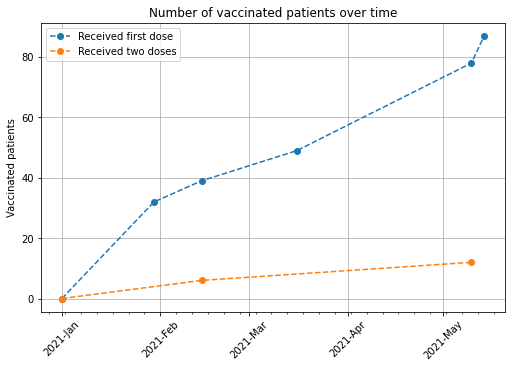

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)
ax.plot(vax_count["date"], vax_count["count"],  '--o', label="Received first dose")
ax.plot(fully_vax_count["date"], fully_vax_count["count"],  '--o', label="Received two doses")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.tick_params(axis = 'x', rotation = 45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.grid(True)
ax.set_ylabel("Vaccinated patients")
ax.set_title("Number of vaccinated patients over time")
ax.legend()
plt.show()


**Note**: 
technically the dashed lines on this plot do not reflect the real intermediate datapoints. A more realistic plot would depict a stepped ladder function, since patients are not getting vaccinated outside of the vaccination event dates. However, since such a plot would be less visually informative and would not reflect the overall trend as well, we have elected to use the plot you can see above. 

**Another note**: 
the task asked to specifically plot counts for first-dose and second-dose patients. Perhaps it would make sense to instead track the counts of partially and fully vaccinated patients. Since within the sample data all vaccines require exactly two doses for a full vaccination, this change would not be visible at all, but as the database expands the difference in the two methonds would become more apparent.

### Problem 10
#### Suppose that we found out that the nurse with ssNo ”19740919-7140” has been tested positive for corona on 15.5.2021. This problem aims to find out the social security numbers and names of the patients and staff members that the nurse may have met in vaccination events in the past 10 days.

We first take the necessarry tables for this task: StaffMember, VaccinationEvent, VaccinationShift, Attend, Patient

In [37]:
staff_members_df = pd.read_sql('SELECT * FROM StaffMember', psql_conn)
vaccination_event_df = pd.read_sql('SELECT * FROM VaccinationEvent', psql_conn)
shifts_df = pd.read_sql('SELECT * FROM VaccinationShift', psql_conn)
attend_df = pd.read_sql('SELECT * FROM Attend', psql_conn)
patients_df = pd.read_sql('SELECT * FROM Patient', psql_conn)

We first find vaccination events that happened ten days before the nurse with social security number 19740919-7140 tested positive for corona (ones between 05-05-2021 and 15-05-2021), and add the records of weekday into these records.

In [38]:
vaccination_event_df['date'] = pd.to_datetime(vaccination_event_df['date'])
vaccination_event_df = vaccination_event_df[(vaccination_event_df['date'] >= pd.Timestamp(2021,5,5)) & (vaccination_event_df['date'] <= pd.Timestamp(2021,5,15))]
vaccination_event_df['weekday'] = vaccination_event_df['date'].dt.day_name()
vaccination_event_df.head()

,date,location,batchid,weekday
4,2021-05-10,Tapiola Health Center,B11,Monday
5,2021-05-14,Iso Omena Vaccination Point,B30,Friday
6,2021-05-10,Sanomala Vaccination Point,B01,Monday
7,2021-05-10,Myyrmäki Energia Areena,B17,Monday


We find the shifts of the nurse to then find all the vaccination events that the nurse could have gone to.

In [39]:
nurse_shifts_df = shifts_df[shifts_df['worker'] == '19740919-7140']
nurse_vaccinations = pd.merge(vaccination_event_df, nurse_shifts_df, left_on = ['location', 'weekday'], right_on = ['location', 'weekday'])
nurse_vaccinations = nurse_vaccinations[['location', 'weekday', 'date']]
nurse_vaccinations.head()

,location,weekday,date
0,Tapiola Health Center,Monday,2021-05-10


We can now find patients and staff members that potentially had contacts with the nurse for the last ten days.

In [40]:
attend_df['date'] = pd.to_datetime(attend_df['date'])
potential_patients = pd.merge(attend_df, nurse_vaccinations, left_on = ['date', 'location'], right_on = ['date', 'location'])
potential_patients = potential_patients[['patient']]
potential_patients = pd.merge(potential_patients, patients_df, left_on = ['patient'], right_on = ['ssno'])
potential_patients = potential_patients[['ssno', 'name']]
potential_patients.head()

,ssno,name
0,210318-737O,Corine Hane
1,130205-474D,Elenora Sawayn
2,830820-576C,Loyal Hoeger
3,871128-519R,Flossie Torp
4,090416-443L,Aliyah Harber


In [41]:
potential_staff = pd.merge(shifts_df, nurse_vaccinations, left_on = ['location', 'weekday'], right_on = ['location', 'weekday'])
potential_staff = potential_staff[potential_staff['worker'] != '19740919-7140']
potential_staff = pd.merge(potential_staff, staff_members_df, left_on = 'worker', right_on = 'ssno')
potential_staff = potential_staff[['ssno', 'name']]
potential_staff.head()

,ssno,name
0,19920802-4854,Kaden Tromp
1,19940615-4448,Jordy Hilpert


In [42]:
potential_people = pd.concat([potential_patients, potential_staff])
potential_people

,ssno,name
0,210318-737O,Corine Hane
1,130205-474D,Elenora Sawayn
2,830820-576C,Loyal Hoeger
3,871128-519R,Flossie Torp
4,090416-443L,Aliyah Harber
5,060421-302M,Faustino Barton
6,960629-4156,Rossie Spinka
7,930804-509I,Fay Ryan
8,090226-5673,Dr. Lamont Ferry
9,010327-525G,Dr. Mireille Hansen


In [43]:
# closing connection
if (connection):
            psql_conn.close()
            connection.close()
            print("PostgreSQL connection is closed")

PostgreSQL connection is closed
